In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/wesad-wearable-stress-affect-detection-dataset/WESAD/wesad_readme.pdf
/kaggle/input/wesad-wearable-stress-affect-detection-dataset/WESAD/S14/S14.pkl
/kaggle/input/wesad-wearable-stress-affect-detection-dataset/WESAD/S14/S14_quest.csv
/kaggle/input/wesad-wearable-stress-affect-detection-dataset/WESAD/S14/S14_respiban.txt
/kaggle/input/wesad-wearable-stress-affect-detection-dataset/WESAD/S14/S14_readme.txt
/kaggle/input/wesad-wearable-stress-affect-detection-dataset/WESAD/S14/S14_E4_Data/HR.csv
/kaggle/input/wesad-wearable-stress-affect-detection-dataset/WESAD/S14/S14_E4_Data/IBI.csv
/kaggle/input/wesad-wearable-stress-affect-detection-dataset/WESAD/S14/S14_E4_Data/BVP.csv
/kaggle/input/wesad-wearable-stress-affect-detection-dataset/WESAD/S14/S14_E4_Data/EDA.csv
/kaggle/input/wesad-wearable-stress-affect-detection-dataset/WESAD/S14/S14_E4_Data/info.txt
/kaggle/input/wesad-wearable-stress-affect-detection-dataset/WESAD/S14/S14_E4_Data/TEMP.csv
/kaggle/input/wesad-wearable-st

In [4]:
import numpy as np
import pandas as pd
import pickle
import tensorflow as tf

import matplotlib.pyplot as plt

from tensorflow.keras import layers, models, optimizers, callbacks
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

In [7]:
# CHANGE THIS if your dataset is in a different location
BASE_PATH = "/kaggle/input/wesad-wearable-stress-affect-detection-dataset/WESAD"

import os
print("WESAD path exists:", os.path.exists(BASE_PATH))
print(os.listdir(BASE_PATH))

WESAD path exists: True
['S14', 'S11', 'S13', 'S10', 'S8', 'S5', 'S7', 'S9', 'S15', 'wesad_readme.pdf', 'S2', 'S6', 'S3', 'S4', 'S16', 'S17']


In [17]:
def load_subject_wrist(subject_pkl_path):
    with open(subject_pkl_path, "rb") as f:
        data = pickle.load(f, encoding="latin1")

    wrist = data["signal"]["wrist"]

    acc = np.array(wrist["ACC"])   # 32Hz
    bvp = np.array(wrist["BVP"])   # 64Hz
    eda = np.array(wrist["EDA"])   # 4Hz
    temp = np.array(wrist["TEMP"]) # 4Hz

    # Downsample to 4Hz
    acc_ds = acc[::8]
    bvp_ds = bvp[::16]
    eda_ds = eda
    temp_ds = temp

    min_len = min(len(acc_ds), len(bvp_ds), len(eda_ds), len(temp_ds))

    acc_ds = acc_ds[:min_len]
    bvp_ds = bvp_ds[:min_len].reshape(-1,1)
    eda_ds = eda_ds[:min_len].reshape(-1,1)
    temp_ds = temp_ds[:min_len].reshape(-1,1)

    X = np.hstack([acc_ds, bvp_ds, eda_ds, temp_ds])

    labels = np.array(data["label"])
    labels_ds = labels[::175][:min_len]

    y = (labels_ds == 3).astype(int)
    return X, y

# Define forecasting horizons (in seconds)
FORECAST_HORIZONS = [0, 60, 120, 180]    # detection / 1min / 2min / 3min ahead

def create_windows(signals, labels, window_size, forecast_shift, target_map):
    X, y = [], []
    T = len(labels)

    for start in range(T - window_size - forecast_shift):
        end = start + window_size
        future = end + forecast_shift

        lbl = int(labels[future])
        if lbl not in target_map:
            continue

        X.append(signals[start:end])
        y.append(target_map[lbl])

    return np.array(X), np.array(y)


def prepare_dataset(base_path=BASE_PATH):

    all_X, all_y = [], []

    for subj in sorted(os.listdir(base_path)):
        if subj.startswith("S"):
            pkl_path = os.path.join(base_path, subj, subj + ".pkl")
            if not os.path.isfile(pkl_path):
                continue

            print("Loading:", subj)
            Xs, ys = load_subject_wrist(pkl_path)
            target_map = {0: 0, 1: 1}  # or adjust depending on your labels
            window_size = 256
            forecast_shift = 0
            Xw, yw = create_windows(Xs, ys, window_size, forecast_shift, target_map)
            all_X.append(Xw)
            all_y.append(yw)

    X = np.vstack(all_X)
    y = np.concatenate(all_y)

    print("Dataset shape:", X.shape)
    print("Label distribution:", np.bincount(y))

    # Standard normalization
    ns, ts, nf = X.shape
    X2d = X.reshape(-1, nf)
    scaler = StandardScaler()
    X2d = scaler.fit_transform(X2d)
    X = X2d.reshape(ns, ts, nf)

    return train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [18]:
X_train, X_test, y_train, y_test = prepare_dataset()
input_shape = (X_train.shape[1], X_train.shape[2])

Loading: S10
Loading: S11
Loading: S13
Loading: S14
Loading: S15
Loading: S16
Loading: S17
Loading: S2
Loading: S3
Loading: S4
Loading: S5
Loading: S6
Loading: S7
Loading: S8
Loading: S9
Dataset shape: (343632, 256, 6)
Label distribution: [321332  22300]


In [21]:
# ==========================================================
# Proactive Hybrid CNN–BiLSTM–Attention Model
# ==========================================================
def build_proactive_model(input_shape):
    inputs = layers.Input(shape=input_shape)

    # 1) Temporal Convolution
    x = layers.Conv1D(256, 7, padding="same", activation="relu")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.25)(x)

    # 2) BiLSTM
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)
    x = layers.Dropout(0.3)(x)
    
    # 3) Multi-Head Self-Attention
    attn = layers.MultiHeadAttention(num_heads=4, key_dim=64)(x, x)
    x = layers.Add()([x, attn])
    x = layers.LayerNormalization()(x)

    # Feed-forward
    ff = layers.Dense(256, activation="relu")(x)
    x = layers.Add()([x, ff])
    x = layers.LayerNormalization()(x)

    # 4) Attention weights
    raw_att = layers.Dense(1, activation="tanh")(x)
    att_weights = layers.Softmax(axis=1, name="attention_weights")(raw_att)

    weighted_x = layers.Multiply()([att_weights, x])
    context = layers.Lambda(lambda t: tf.reduce_sum(t, axis=1))(weighted_x)

    # 5) Classifier
    x = layers.Dense(256, activation="relu")(context)
    x = layers.Dropout(0.4)(x)
    output = layers.Dense(1, activation="sigmoid")(x)

    model = models.Model(inputs, output)
    interpret = models.Model(inputs, att_weights)

    model.compile(optimizer=optimizers.AdamW(1e-4),
                  loss="binary_crossentropy",
                  metrics=["accuracy", tf.keras.metrics.AUC()])

    return model, interpret

In [22]:
# ======================================================
# FORECASTING EXPERIMENT
# ======================================================

print("\n===== FORECASTING EXPERIMENT =====")

# We reload raw subjects to apply forecasting properly
window_size = 256
sampling_rate = 4  # wrist data downsampled to 4 Hz
step = 1
target_map = {0: 0, 1: 1}

FORECAST_HORIZONS = [0, 60, 120, 180]   # seconds ahead
forecast_results = {}

for horizon in FORECAST_HORIZONS:
    print(f"\nForecasting {horizon} seconds ahead...")

    forecast_shift = horizon * sampling_rate   # convert seconds → samples
    all_Xh, all_yh = [], []

    for subj in sorted(os.listdir(BASE_PATH)):
        if not subj.startswith("S"):
            continue

        pkl_path = os.path.join(BASE_PATH, subj, subj + ".pkl")
        if not os.path.isfile(pkl_path):
            continue

        # Load wrist signals
        Xs, ys = load_subject_wrist(pkl_path)

        # Build windows with future labels
        Xw, yw = create_windows(
            Xs, ys,
            window_size=window_size,
            forecast_shift=forecast_shift,
            target_map=target_map
        )

        all_Xh.append(Xw)
        all_yh.append(yw)

    Xh = np.vstack(all_Xh)
    yh = np.concatenate(all_yh)

    # Normalize
    ns, ts, nf = Xh.shape
    scaler = StandardScaler()
    Xh2d = Xh.reshape(-1, nf)
    Xh_scaled = scaler.fit_transform(Xh2d).reshape(ns, ts, nf)

    # Split
    Xh_train, Xh_test, yh_train, yh_test = train_test_split(
        Xh_scaled, yh, test_size=0.2, random_state=42, stratify=yh
    )

    # Build proactive model
    model_h, _ = build_proactive_model(input_shape)

    model_h.fit(
        Xh_train, yh_train,
        epochs=12,
        batch_size=64,
        validation_split=0.2,
        verbose=0
    )

    yh_prob = model_h.predict(Xh_test).ravel()
    yh_pred = (yh_prob > 0.5).astype(int)

    acc = np.mean(yh_pred == yh_test)
    forecast_results[horizon] = acc

    print(f"Accuracy for {horizon} sec ahead = {acc:.4f}")

print("\n===== FORECASTING SUMMARY =====")
for h, acc in forecast_results.items():
    print(f"{h} sec → {acc:.4f}")


===== FORECASTING EXPERIMENT =====

Forecasting 0 seconds ahead...
2148/2148 ━━━━━━━━━━━━━━━━━━━━ 33s 15ms/step
Accuracy for 0 sec ahead = 0.9987

Forecasting 60 seconds ahead...
2126/2126 ━━━━━━━━━━━━━━━━━━━━ 33s 15ms/step
Accuracy for 60 sec ahead = 0.9983

Forecasting 120 seconds ahead...
2103/2103 ━━━━━━━━━━━━━━━━━━━━ 33s 15ms/step
Accuracy for 120 sec ahead = 0.9974

Forecasting 180 seconds ahead...
2081/2081 ━━━━━━━━━━━━━━━━━━━━ 32s 15ms/step
Accuracy for 180 sec ahead = 0.9968

===== FORECASTING SUMMARY =====
0 sec → 0.9987
60 sec → 0.9983
120 sec → 0.9974
180 sec → 0.9968


In [23]:
# ==============================================
# BASELINE MODEL 1 — LSTM ONLY
# ==============================================
def build_lstm_baseline(input_shape):
    inputs = layers.Input(shape=input_shape)
    x = layers.Bidirectional(layers.LSTM(64))(inputs)
    x = layers.Dense(32, activation='relu')(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    model = models.Model(inputs, outputs)
    model.compile(optimizer=optimizers.Adam(1e-4),
                  loss='binary_crossentropy', metrics=['accuracy'])
    return model

lstm_model = build_lstm_baseline(input_shape)
lstm_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

lstm_pred = (lstm_model.predict(X_test) > 0.5).astype(int)
print("\nLSTM Baseline Results:\n", classification_report(y_test, lstm_pred))

Epoch 1/10
6873/6873 ━━━━━━━━━━━━━━━━━━━━ 134s 19ms/step - accuracy: 0.9344 - loss: 0.2001 - val_accuracy: 0.9651 - val_loss: 0.0851
Epoch 2/10
6873/6873 ━━━━━━━━━━━━━━━━━━━━ 130s 19ms/step - accuracy: 0.9662 - loss: 0.0882 - val_accuracy: 0.9721 - val_loss: 0.0652
Epoch 3/10
6873/6873 ━━━━━━━━━━━━━━━━━━━━ 130s 19ms/step - accuracy: 0.9773 - loss: 0.0645 - val_accuracy: 0.9796 - val_loss: 0.0522
Epoch 4/10
6873/6873 ━━━━━━━━━━━━━━━━━━━━ 130s 19ms/step - accuracy: 0.9832 - loss: 0.0481 - val_accuracy: 0.9888 - val_loss: 0.0317
Epoch 5/10
6873/6873 ━━━━━━━━━━━━━━━━━━━━ 130s 19ms/step - accuracy: 0.9823 - loss: 0.0501 - val_accuracy: 0.9805 - val_loss: 0.0522
Epoch 6/10
6873/6873 ━━━━━━━━━━━━━━━━━━━━ 130s 19ms/step - accuracy: 0.9834 - loss: 0.0462 - val_accuracy: 0.9912 - val_loss: 0.0298
Epoch 7/10
6873/6873 ━━━━━━━━━━━━━━━━━━━━ 130s 19ms/step - accuracy: 0.9899 - loss: 0.0308 - val_accuracy: 0.9909 - val_loss: 0.0280
Epoch 8/10
6873/6873 ━━━━━━━━━━━━━━━━━━━━ 131s 19ms/step - accuracy: 

NameError: name 'classification_report' is not defined

In [24]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
print("\nLSTM Baseline Results:\n", classification_report(y_test, lstm_pred))


LSTM Baseline Results:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99     64267
           1       0.93      0.89      0.91      4460

    accuracy                           0.99     68727
   macro avg       0.96      0.94      0.95     68727
weighted avg       0.99      0.99      0.99     68727



In [25]:
# ==============================================
# BASELINE MODEL 2 — CNN ONLY
# ==============================================
def build_cnn_baseline(input_shape):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv1D(64, 7, padding='same', activation='relu')(inputs)
    x = layers.Conv1D(64, 7, padding='same', activation='relu')(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(32, activation='relu')(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    model = models.Model(inputs, outputs)
    model.compile(optimizer=optimizers.Adam(1e-4),
                  loss='binary_crossentropy', metrics=['accuracy'])
    return model

cnn_model = build_cnn_baseline(input_shape)
cnn_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

cnn_pred = (cnn_model.predict(X_test) > 0.5).astype(int)
print("\nCNN Baseline Results:\n", classification_report(y_test, cnn_pred))

Epoch 1/10


I0000 00:00:1765420212.487999     169 service.cc:148] XLA service 0x7ef591726de0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1765420212.489067     169 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1765420212.489105     169 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  48/6873 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - accuracy: 0.7016 - loss: 0.6209 

I0000 00:00:1765420214.102675     169 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


6873/6873 ━━━━━━━━━━━━━━━━━━━━ 31s 4ms/step - accuracy: 0.9389 - loss: 0.1780 - val_accuracy: 0.9810 - val_loss: 0.0610
Epoch 2/10
6873/6873 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - accuracy: 0.9834 - loss: 0.0536 - val_accuracy: 0.9903 - val_loss: 0.0359
Epoch 3/10
6873/6873 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - accuracy: 0.9893 - loss: 0.0349 - val_accuracy: 0.9909 - val_loss: 0.0277
Epoch 4/10
6873/6873 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - accuracy: 0.9915 - loss: 0.0260 - val_accuracy: 0.9915 - val_loss: 0.0229
Epoch 5/10
6873/6873 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - accuracy: 0.9927 - loss: 0.0209 - val_accuracy: 0.9937 - val_loss: 0.0173
Epoch 6/10
6873/6873 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - accuracy: 0.9940 - loss: 0.0167 - val_accuracy: 0.9955 - val_loss: 0.0149
Epoch 7/10
6873/6873 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - accuracy: 0.9948 - loss: 0.0140 - val_accuracy: 0.9957 - val_loss: 0.0121
Epoch 8/10
6873/6873 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - accuracy: 0.9956 - loss: 0.0119 - val

In [26]:
model, viz = build_proactive_model(input_shape)
model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 256, 6)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 256, 256)  │     11,008 │ input_layer_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256)  │      1,024 │ conv1d_6[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_16          │ (None, 256, 256)  │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_6     │ (None, 256, 256)  │    394,240 │ dropout_16[0][0]  │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_17          │ (None, 256, 256)  │          0 │ bidirectional_6[… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 256, 256)  │    263,168 │ dropout_17[0][0], │
│ (MultiHeadAttentio… │                   │            │ dropout_17[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_8 (Add)         │ (None, 256, 256)  │          0 │ dropout_17[0][0], │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 256, 256)  │        512 │ add_8[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_22 (Dense)    │ (None, 256, 256)  │     65,792 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_9 (Add)         │ (None, 256, 256)  │          0 │ layer_normalizat… │
│                     │                   │            │ dense_22[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 256, 256)  │        512 │ add_9[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_23 (Dense)    │ (None, 256, 1)    │        257 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_weights   │ (None, 256, 1)    │          0 │ dense_23[0][0]    │
│ (Softmax)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_4          │ (None, 256, 256)  │          0 │ attention_weight… │
│ (Multiply)          │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_4 (Lambda)   │ (None, 256)       │          0 │ multiply_4[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_24 (Dense)    │ (None, 256)       │     65,792 │ lambda_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_19          │ (None, 256)       │          0 │ dense_24[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 802,562 (3.06 MB)

 Trainable params: 802,050 (3.06 MB)

 Non-trainable params: 512 (2.00 KB)

In [27]:
# ==========================================================
# Train Proactive Model and Evaluation
# ==========================================================
class_weights_dict = {
    i: w for i, w in enumerate(
        class_weight.compute_class_weight("balanced",
                                          classes=np.unique(y_train),
                                          y=y_train)
    )
}

callbacks_list = [
    callbacks.EarlyStopping(patience=6, restore_best_weights=True),
    callbacks.ReduceLROnPlateau(factor=0.5, patience=3)
]

history = model.fit(
    X_train, y_train,
    epochs=40,
    batch_size=64,
    validation_data=(X_test, y_test),
    class_weight=class_weights_dict,
    callbacks=callbacks_list
)

loss, acc, auc_val = model.evaluate(X_test, y_test)
print(f"\nFinal Accuracy: {acc*100:.2f}% | AUC={auc_val:.3f}")

y_prob = model.predict(X_test).ravel()
y_pred = (y_prob > 0.5).astype(int)

print("\nClassification Report:\n", classification_report(y_test, y_pred))

Epoch 1/40
4296/4296 ━━━━━━━━━━━━━━━━━━━━ 384s 88ms/step - accuracy: 0.9253 - auc_4: 0.9760 - loss: 0.1596 - val_accuracy: 0.9762 - val_auc_4: 0.9979 - val_loss: 0.0746 - learning_rate: 1.0000e-04
Epoch 2/40
4296/4296 ━━━━━━━━━━━━━━━━━━━━ 378s 88ms/step - accuracy: 0.9827 - auc_4: 0.9972 - loss: 0.0419 - val_accuracy: 0.9913 - val_auc_4: 0.9990 - val_loss: 0.0321 - learning_rate: 1.0000e-04
Epoch 3/40
4296/4296 ━━━━━━━━━━━━━━━━━━━━ 378s 88ms/step - accuracy: 0.9846 - auc_4: 0.9974 - loss: 0.0365 - val_accuracy: 0.9928 - val_auc_4: 0.9989 - val_loss: 0.0283 - learning_rate: 1.0000e-04
Epoch 4/40
4296/4296 ━━━━━━━━━━━━━━━━━━━━ 378s 88ms/step - accuracy: 0.9895 - auc_4: 0.9983 - loss: 0.0260 - val_accuracy: 0.9940 - val_auc_4: 0.9988 - val_loss: 0.0262 - learning_rate: 1.0000e-04
Epoch 5/40
4296/4296 ━━━━━━━━━━━━━━━━━━━━ 378s 88ms/step - accuracy: 0.9902 - auc_4: 0.9984 - loss: 0.0248 - val_accuracy: 0.9951 - val_auc_4: 0.9990 - val_loss: 0.0212 - learning_rate: 1.0000e-04
Epoch 6/40
4296

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=10000.0 (msgs/sec)
ServerApp.rate_limit_window=1.0 (secs)



4296/4296 ━━━━━━━━━━━━━━━━━━━━ 378s 88ms/step - accuracy: 0.9981 - auc_4: 0.9999 - loss: 0.0038 - val_accuracy: 0.9985 - val_auc_4: 0.9999 - val_loss: 0.0046 - learning_rate: 1.2500e-05
Epoch 28/40
4296/4296 ━━━━━━━━━━━━━━━━━━━━ 378s 88ms/step - accuracy: 0.9982 - auc_4: 0.9999 - loss: 0.0037 - val_accuracy: 0.9986 - val_auc_4: 1.0000 - val_loss: 0.0035 - learning_rate: 1.2500e-05
Epoch 29/40
4296/4296 ━━━━━━━━━━━━━━━━━━━━ 378s 88ms/step - accuracy: 0.9984 - auc_4: 0.9999 - loss: 0.0035 - val_accuracy: 0.9987 - val_auc_4: 1.0000 - val_loss: 0.0034 - learning_rate: 1.2500e-05
Epoch 30/40
4296/4296 ━━━━━━━━━━━━━━━━━━━━ 378s 88ms/step - accuracy: 0.9983 - auc_4: 0.9999 - loss: 0.0038 - val_accuracy: 0.9987 - val_auc_4: 1.0000 - val_loss: 0.0034 - learning_rate: 1.2500e-05
Epoch 31/40
4296/4296 ━━━━━━━━━━━━━━━━━━━━ 378s 88ms/step - accuracy: 0.9984 - auc_4: 0.9999 - loss: 0.0034 - val_accuracy: 0.9983 - val_auc_4: 1.0000 - val_loss: 0.0050 - learning_rate: 1.2500e-05
Epoch 32/40
4296/4296 

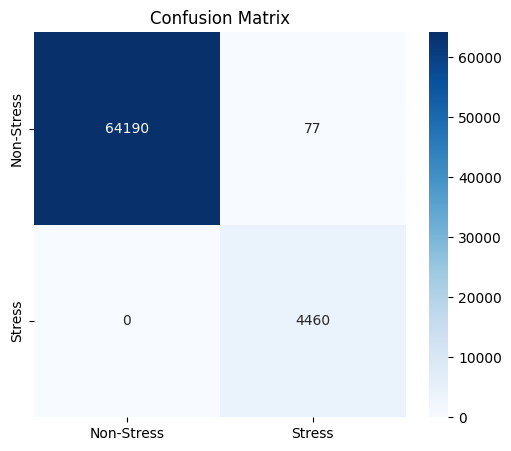

In [30]:
# ==========================================================
# Confusion Matrix
# ==========================================================
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, cmap="Blues", fmt='d',
            xticklabels=["Non-Stress","Stress"],
            yticklabels=["Non-Stress","Stress"])
plt.title("Confusion Matrix")
plt.show()

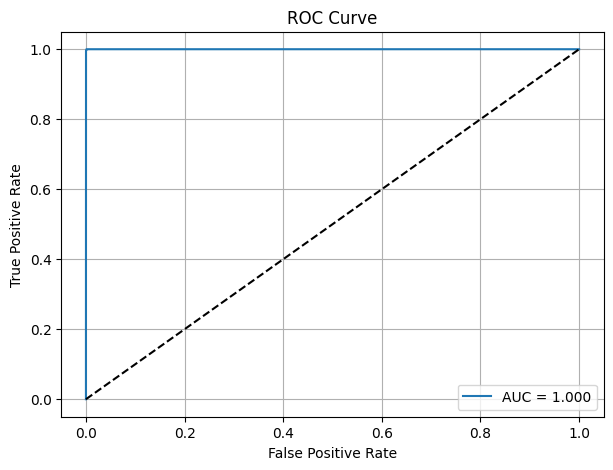

In [31]:
# ==========================================================
# ROC Curve
# ==========================================================
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

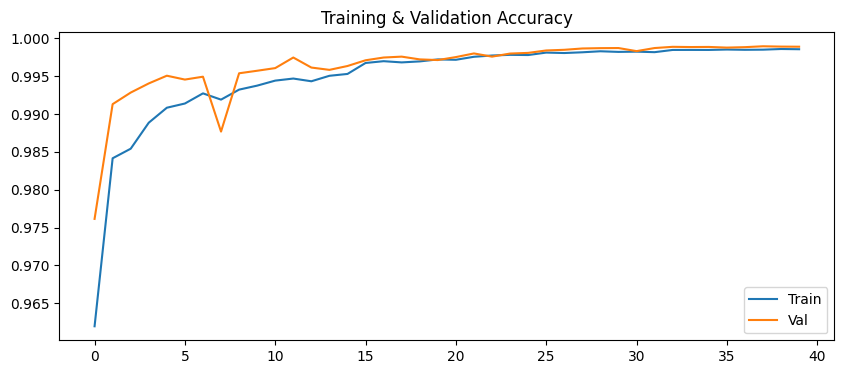

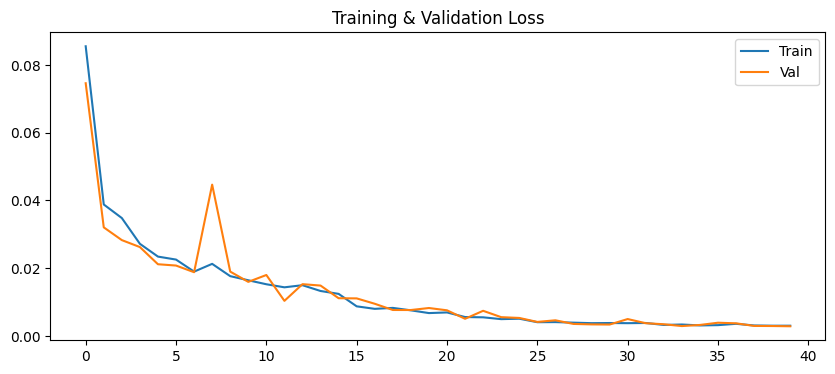

In [32]:
# ==========================================================
# Training Curves
# ==========================================================
plt.figure(figsize=(10,4))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Training & Validation Accuracy")
plt.legend(["Train","Val"])
plt.show()

plt.figure(figsize=(10,4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Training & Validation Loss")
plt.legend(["Train","Val"])
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


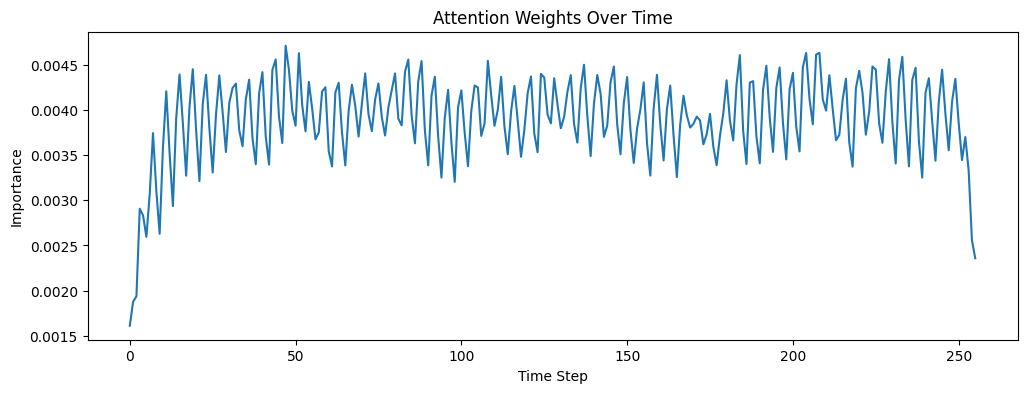

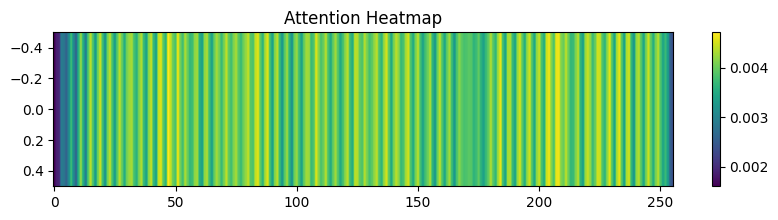

In [33]:
# ==========================================================
# Attention Visualization
# ==========================================================
sample = X_test[:1]
att = viz.predict(sample).flatten()

plt.figure(figsize=(12,4))
plt.plot(att)
plt.title("Attention Weights Over Time")
plt.xlabel("Time Step")
plt.ylabel("Importance")
plt.show()

plt.figure(figsize=(10,2))
plt.imshow(att.reshape(1,-1), cmap="viridis", aspect="auto")
plt.colorbar()
plt.title("Attention Heatmap")
plt.show()

In [34]:
model.save("proactive_stress_model.h5")
print("Saved proactive_stress_model.h5")

Saved proactive_stress_model.h5
